In [1]:
# 필요한 모듈 import하기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
import cv2
import os

In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices("GPU")

if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("No GPU devices found.")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 파일로부터 영상을 읽어서 data에 저장하기
labels = ['PNEUMONIA', 'NORMAL']
img_size = 299
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
train = get_training_data('drive/MyDrive/com_data/chest_xray/train')
test = get_training_data('drive/MyDrive/com_data/chest_xray/test')
val = get_training_data('drive/MyDrive/com_data/chest_xray/val')

KeyboardInterrupt: ignored

In [7]:
img_size = 299
labels = ['PNEUMONIA', 'NORMAL']
def get_training_data(data_dir):
    data = []
    counts = [0, 0]  # Keep track of the number of images for each class
    max_count = 100  # Maximum number of images for each class

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                if counts[class_num] >= max_count:
                    # Skip if the maximum count is reached for the current class
                    continue

                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
                counts[class_num] += 1
            except Exception as e:
                print(e)
    return np.array(data)


In [5]:
# Get limited training data
train = get_training_data('drive/MyDrive/com_data/chest_xray/train')


<ipython-input-4-2d5f97217cd0>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [8]:
test = get_training_data('drive/MyDrive/com_data/chest_xray/test')
val = get_training_data('drive/MyDrive/com_data/chest_xray/val')


<ipython-input-7-c5a3236e512e>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [9]:
print("학습용데이터:", train.shape)
print("테스트데이터:", test.shape)
print("검증데이터:", val.shape)

학습용데이터: (1000, 2)
테스트데이터: (200, 2)
검증데이터: (16, 2)


<Axes: >

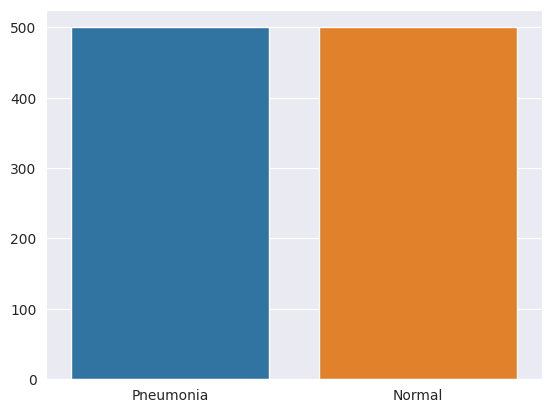

In [6]:
import seaborn as sns

# Create an empty list to store the labels
l = []

# Iterate through the train dataset and append the labels to the list
for i in train:
    if i[1] == 0:
        l.append("Pneumonia")
    else:
        l.append("Normal")

# Use seaborn to plot a barplot of the labels
sns.set_style('darkgrid')
sns.barplot(x=["Pneumonia", "Normal"], y=[l.count("Pneumonia"), l.count("Normal")])


Text(0.5, 1.0, 'NORMAL')

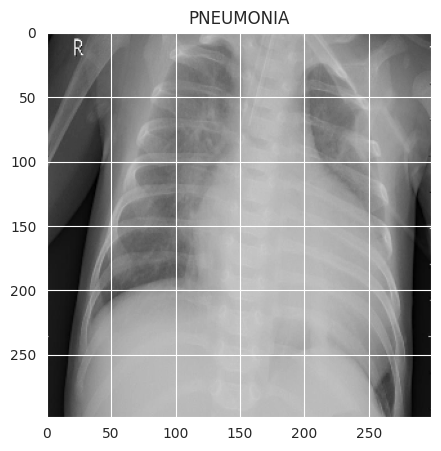

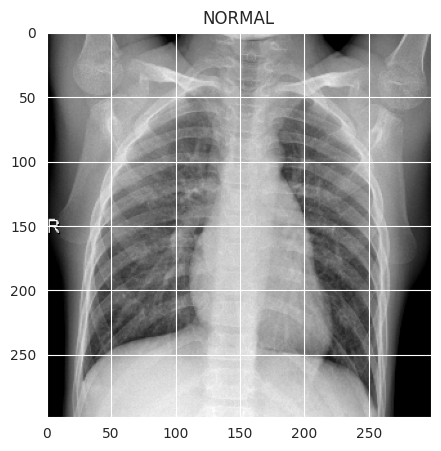

In [10]:
#영상으로 보이기
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [11]:
x_train = []
y_train = []

x_test = []
y_test = []

x_val = []
y_val = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [12]:
# 데이터를 Normalize 0~255  --->   0~1
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [13]:
# Repeat the single channel three times along the last axis
x_train = np.repeat(x_train, 3, axis=-1)
x_val = np.repeat(x_val, 3, axis=-1)
x_test = np.repeat(x_test, 3, axis=-1)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)
# Reshape the array to (number_of_samples, img_size, img_size, 3)
x_train = x_train.reshape(-1, img_size, img_size, 3)
x_val = x_val.reshape(-1, img_size, img_size, 3)
x_test = x_test.reshape(-1, img_size, img_size, 3)

In [ ]:
# 딥러닝을 위해 data를 resize
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

ValueError: ignored

In [14]:
# data augmentation하기 (overfitting을 막고, 데이터셋내의 데이터 불균형도 어느 정도 해소)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [15]:
model = keras.applications.InceptionV3(include_top=True)
print(model.summary())

96112376/96112376 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)           

In [16]:
base_inputs = model.layers[0].input
base_outputs = model.layers[-2].output
classifier = layers.Dense(2)(base_outputs)
model = keras.Model(inputs=base_inputs, outputs=classifier)
optimizer = tf.keras.optimizers.Adam()
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [17]:
#learning_rate를 줄이는 방법. 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 5, verbose=1,factor=0.3, min_lr=0.000001)

In [18]:
print(x_train.shape)
print(y_train.shape)

(1000, 299, 299, 3)
(1000,)


In [19]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 ,callbacks = [learning_rate_reduction])

Epoch 1/12
32/32 [==============================] - ETA: 0s - loss: 0.3189 - accuracy: 0.8760

32/32 [==============================] - 87s 910ms/step - loss: 0.3189 - accuracy: 0.8760 - lr: 0.0010
Epoch 2/12
32/32 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9390

32/32 [==============================] - 25s 766ms/step - loss: 0.1656 - accuracy: 0.9390 - lr: 0.0010
Epoch 3/12
32/32 [==============================] - ETA: 0s - loss: 0.1484 - accuracy: 0.9460

32/32 [==============================] - 25s 779ms/step - loss: 0.1484 - accuracy: 0.9460 - lr: 0.0010
Epoch 4/12
32/32 [==============================] - ETA: 0s - loss: 0.1041 - accuracy: 0.9570

32/32 [==============================] - 25s 780ms/step - loss: 0.1041 - accuracy: 0.9570 - lr: 0.0010
Epoch 5/12
32/32 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9660

32/32 [==============================] - 26s 798ms/step - loss: 0.1026 - accuracy: 0.9660 - lr: 0.0010
Epoch 6/12
32/32 [==============================] - ETA: 0s - loss: 0.1372 - accuracy: 0.9520

32/32 [==============================] - 24s 732ms/step - loss: 0.1372 - accuracy: 0.9520 - lr: 0.0010
Epoch 7/12
32/32 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9630

32/32 [==============================] - 27s 843ms/step - loss: 0.1092 - accuracy: 0.9630 - lr: 0.0010
Epoch 8/12
32/32 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9640

32/32 [==============================] - 25s 762ms/step - loss: 0.1149 - accuracy: 0.9640 - lr: 0.0010
Epoch 9/12
32/32 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9590

32/32 [==============================] - 25s 776ms/step - loss: 0.1115 - accuracy: 0.9590 - lr: 0.0010
Epoch 10/12
32/32 [==============================] - ETA: 0s - loss: 0.0884 - accuracy: 0.9670

32/32 [==============================] - 24s 751ms/step - loss: 0.0884 - accuracy: 0.9670 - lr: 0.0010
Epoch 11/12
32/32 [==============================] - ETA: 0s - loss: 0.0822 - accuracy: 0.9710

32/32 [==============================] - 24s 774ms/step - loss: 0.0822 - accuracy: 0.9710 - lr: 0.0010
Epoch 12/12
32/32 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.9700

32/32 [==============================] - 25s 773ms/step - loss: 0.0996 - accuracy: 0.9700 - lr: 0.0010


In [20]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

7/7 [==============================] - 2s 115ms/step - loss: 2.2329 - accuracy: 0.6450
Loss of the model is -  2.2328882217407227
7/7 [==============================] - 1s 114ms/step - loss: 2.2329 - accuracy: 0.6450
Accuracy of the model is -  64.49999809265137 %


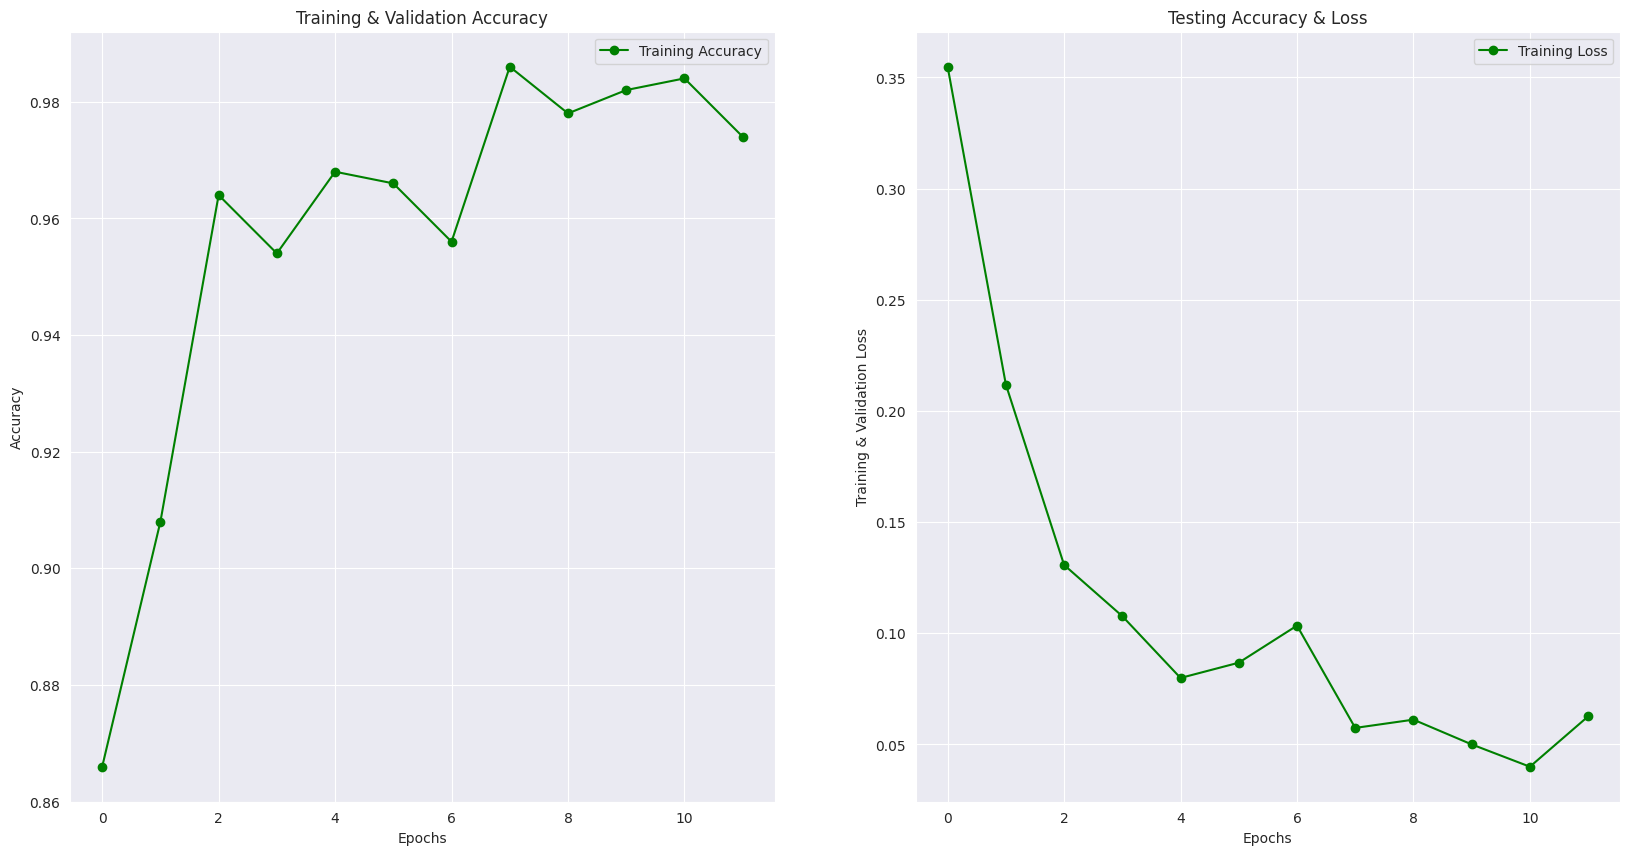

In [26]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [21]:
print("Loss of the model is - " , model.evaluate(x_val,y_val)[0])
print("Accuracy of the model is - " , model.evaluate(x_val,y_val)[1]*100 , "%")

1/1 [==============================] - 2s 2s/step - loss: 5.1682 - accuracy: 0.5000
Loss of the model is -  5.1681809425354
1/1 [==============================] - 0s 93ms/step - loss: 5.1682 - accuracy: 0.5000
Accuracy of the model is -  50.0 %
